In [46]:
from create_coinset import CoinQuery, ImageParams
from coin_loader import AncientCoins
from coin_model import BasicCNN, ResNet, TrainModel
import coin_loader
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
import os

In [47]:
#Set to True if dataset should be created
create = False

if create:
    #Create default dataset in folder 'Resnet_Coinset'
    conn = sql.connect(**cf.config)
    coin_query = CoinQuery(conn)
    image_params = ImageParams(size=256)
    coin_query.create_dataset('Resnet_Coinset', image_params)
    conn.close()

In [48]:
# Set the device to cuda if a GPU is available
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
#Set the desired image size (according to CNN requirements)
img_size = 224

transform = [
            transforms.ToPILImage(),
            transforms.Resize((img_size,img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()]

dataset = AncientCoins("Coinset", img_size, is_gpu, transform=transform)
num_classes = len(dataset.labels.keys())

In [49]:
resnet = ResNet(num_classes)

In [50]:
trainer = TrainModel(device, dataset.trainloader, dataset.valloader, resnet.model, epochs=5)

EPOCH: 1
TRAIN
Loss 3.7222 (3.7222)	Prec@1 0.000 (0.000)
VALIDATION
 * Validation accuracy: Prec@1 60.041 
EPOCH: 2
TRAIN
Loss 1.0500 (1.0500)	Prec@1 75.000 (75.000)
VALIDATION
 * Validation accuracy: Prec@1 61.270 
EPOCH: 3
TRAIN
Loss 0.3710 (0.3710)	Prec@1 93.750 (93.750)
VALIDATION
 * Validation accuracy: Prec@1 70.082 
EPOCH: 4
TRAIN
Loss 0.0908 (0.0908)	Prec@1 100.000 (100.000)
VALIDATION
 * Validation accuracy: Prec@1 63.525 
EPOCH: 5
TRAIN
Loss 0.1281 (0.1281)	Prec@1 96.875 (96.875)
VALIDATION
 * Validation accuracy: Prec@1 70.082 


In [51]:
output, targets = resnet.feature_extraction(dataset.valloader)

In [52]:
min_cluster = 38
max_cluster = 40
for k in range(min_cluster, max_cluster):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(output)
    inertia = kmeans_model.inertia_
    labels = kmeans_model.labels_
    print ("k: ", k, " cost: ", inertia)

k:  38  cost:  74718.953125
k:  39  cost:  74179.34375


In [62]:
cluster_classes = {}
data_classes = {}

for i, t in enumerate(targets):
    if targets[i] not in data_classes:
        data_classes[targets[i]] = set()
    data_classes[targets[i]].add(i)
    if labels[i] not in cluster_classes:
        cluster_classes[labels[i]] = set()
    cluster_classes[labels[i]].add(i)

In [64]:
n = 150
for k in cluster_classes.keys():
    if n in cluster_classes[k]:
        print(cluster_classes[k])
for k in data_classes.keys():
    if n in data_classes[k]:
        print(data_classes[k])

{96, 131, 326, 391, 456, 201, 329, 362, 76, 45, 173, 428, 254, 150, 23, 215, 252, 477, 190}
{257, 131, 391, 20, 150, 23, 425, 428, 45, 46, 173, 190, 326, 456, 201, 329, 76, 211, 215, 477, 96, 362, 252, 125, 254}


In [54]:
c = 0
for i, t in enumerate(targets):
    if t == eq_dict[i]:
        c += 1
        
print(c/len(targets))

0.018442622950819672


In [55]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


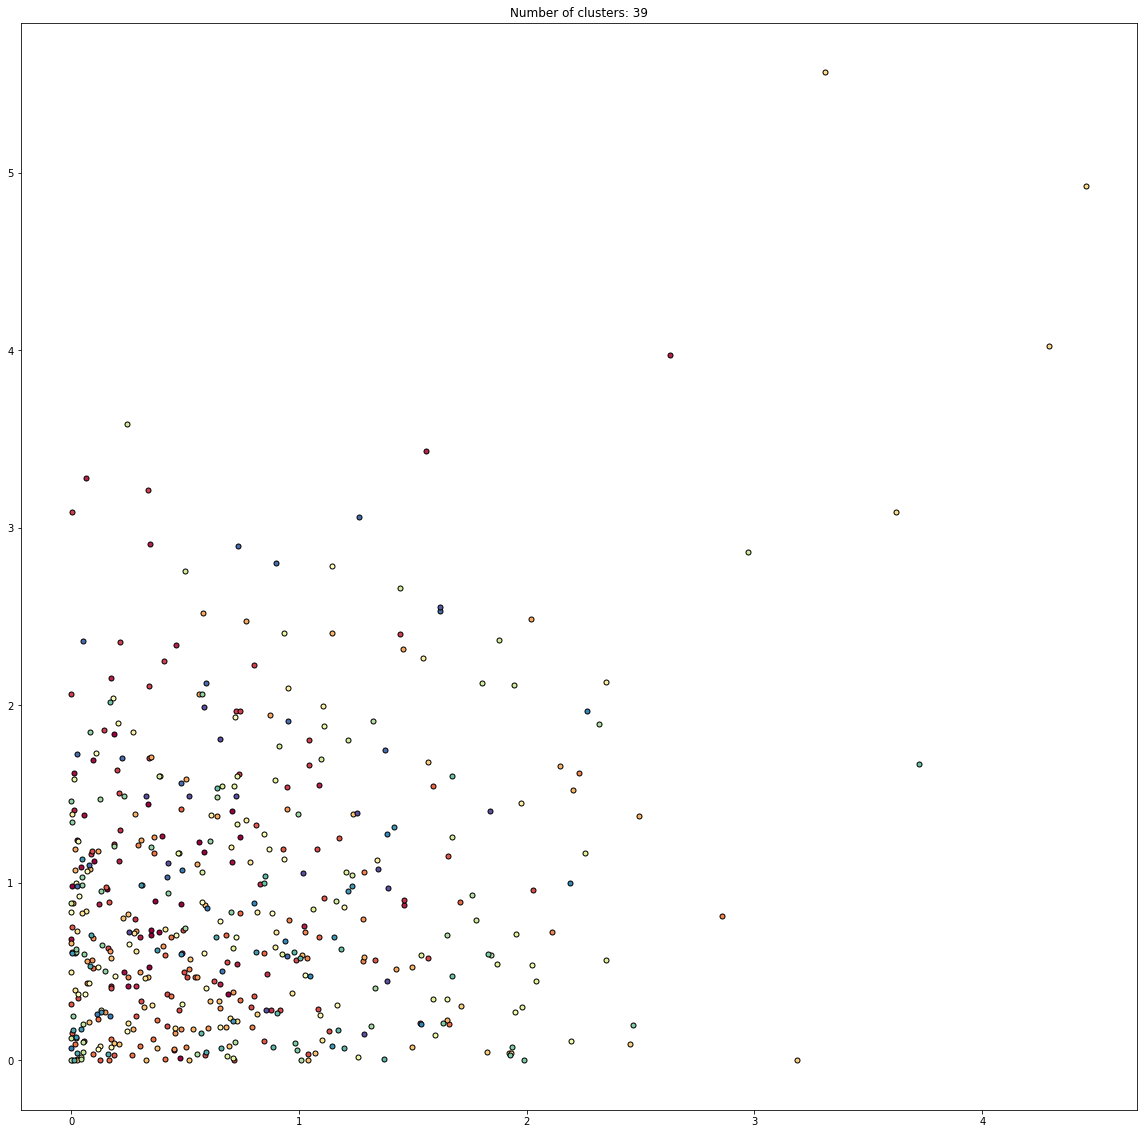

In [67]:
X_embedded = TSNE(n_components=2).fit_transform(output)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
  for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):

    class_member_mask = (labels == k)

    xy = output[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=5)

plt.title('Number of clusters: {}'.format(k+1))
plt.show()